### Results from arduino radiation-board
- Revived a forgotten Libelium/Cooking-hacks [radiation arduino shield](https://www.cooking-hacks.com/documentation/tutorials/geiger-counter-radiation-sensor-board-arduino-raspberry-pi-tutorial/).
- The same board + *J305βγ tube* had produced these results ~5 years back: http://ankostis.blogspot.it/2011/07/blog-post.html
- github: https://github.com/ankostis/radiationsensor

In [39]:
%matplotlib notebook
#%matplotlib inline 
#Plots FAIL with NO GUI!!
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from collections import OrderedDict
from IPython.display import display

In [29]:
files=!ls *.txt 
print(files)

['Ispra-201609-1-OFF.txt', 'Ispra-201609-2.txt', 'Ispra-201609-3.txt', 'Ispra-201609-4.txt', 'Ispra-201609-5.txt', 'IspraHome-20160910-1953.txt', 'IspraHome-20160911-0534.txt', 'IspraHome-20160911-0752.txt', 'IspraHome-20160911-1918.txt', 'IspraHome-Day-0630ToXXXX-20160908.txt', 'IspraHome-Day-1000ToXXXX-20160907.txt', 'IspraHome-Day-1000ToXXXX-20160910.txt', 'IspraHome-Day-1225ToXXXX-20160910.txt', 'IspraHome-Day-1300ToXXXX-20160910.txt', 'IspraHome-Night-0200ToXXXX-20160909.txt', 'IspraHome-Night-2100To1000-20160906.txt', 'IspraHome-Night-2100ToXXXX-20160908.txt', 'IspraHome-Night-2240ToXXXX-20160909.txt']


In [6]:
import io
import re

line_regexs = (
    (re.compile(r'cpm = (?P<clicks>\d+)'), lambda c: c / 6),
    (re.compile(r'.*cpm=\d+, clicks=(?P<clicks>\d+).*'), None),
    (re.compile(r'^(?P<clicks>\d+),(?P<maxcpm>\d+.\d+)'), None),
)
def parse_click_line(l):
    for r, click_fun in line_regexs:
        m = r.search(l)
        if m: 
            res = m.groupdict()
            
            clicks = res['clicks']
            assert str(clicks) == str(int(clicks)), clicks
            clicks = int(clicks)
            if click_fun:
                clicks = click_fun(clicks)
                
            maxcpm = res.get('maxcpm', 0.0)
            if maxcpm:
                maxcpm = float(maxcpm)
            return clicks, maxcpm

def read_clicks(file):
    """:return: Nx1 or Nx2 matrix if 'maxcpm' exists"""
    with io.open(file, 'rt') as fd:
        lines = (parse_click_line(l) for l in fd if l)
        return np.array([l for l in lines if l])

# f='IspraHome-Night-0200ToXXXX-20160909.txt'
# read_clicks(f)

# file_clicks = {f: read_clicks(f) for f in files}
# file_clicks

In [30]:
from datetime import datetime
fname_regexs = [
    re.compile(r'-(?P<time>\d{4})to.+-(?P<date>\d{8})', re.I),
    re.compile(r'-(?P<date>\d{8})-(?P<time>\d{4})', re.I),
]
def parse_fname_time(file):
    for r in fname_regexs:
        m = r.search(file)
        if m:
            tm = '%s%s' %(m.group('date'), m.group('time'))
            tm = datetime.strptime(tm, '%Y%m%d%H%M')
            return tm

file_times = {f: parse_fname_time(f) for f in files}
file_times = {k:v for k,v in file_times.items() if v}
file_times

{'IspraHome-20160910-1953.txt': datetime.datetime(2016, 9, 10, 19, 53),
 'IspraHome-20160911-0534.txt': datetime.datetime(2016, 9, 11, 5, 34),
 'IspraHome-20160911-0752.txt': datetime.datetime(2016, 9, 11, 7, 52),
 'IspraHome-20160911-1918.txt': datetime.datetime(2016, 9, 11, 19, 18),
 'IspraHome-Day-0630ToXXXX-20160908.txt': datetime.datetime(2016, 9, 8, 6, 30),
 'IspraHome-Day-1000ToXXXX-20160907.txt': datetime.datetime(2016, 9, 7, 10, 0),
 'IspraHome-Day-1000ToXXXX-20160910.txt': datetime.datetime(2016, 9, 10, 10, 0),
 'IspraHome-Day-1225ToXXXX-20160910.txt': datetime.datetime(2016, 9, 10, 12, 25),
 'IspraHome-Day-1300ToXXXX-20160910.txt': datetime.datetime(2016, 9, 10, 13, 0),
 'IspraHome-Night-0200ToXXXX-20160909.txt': datetime.datetime(2016, 9, 9, 2, 0),
 'IspraHome-Night-2100To1000-20160906.txt': datetime.datetime(2016, 9, 6, 21, 0),
 'IspraHome-Night-2100ToXXXX-20160908.txt': datetime.datetime(2016, 9, 8, 21, 0),
 'IspraHome-Night-2240ToXXXX-20160909.txt': datetime.datetime(201

In [16]:
def zipdict(*dcts):
    for i in set(dcts[0]).intersection(*dcts[1:]):
            yield (i, tuple(d[i] for d in dcts))

# file_data = zipdict(file_times, file_clicks)
# file_data = sorted(file_data, key=lambda v: v[1][0])

def collect_data(files):
    file_clicks = {f: read_clicks(f) for f in files}
    #print([v.shape for v in file_clicks.values()])
    
    file_times = {f: parse_fname_time(f) for f in files}
    file_times = {k:v for k,v in file_times.items() if v}

    file_data = zipdict(file_times, file_clicks)
    file_data = OrderedDict(sorted(file_data, key=lambda v: v[1][0]))

    return file_data

file_data = collect_data(files)

In [36]:
fname2_regexs = [
    re.compile(r'-\d{6}-\d{1,3}\.txt', re.I),
]
def read_fname2_as_df(file):
    for r in fname2_regexs:
        m = r.search(file)
        if m:
            print('Loading ', file)
            df = pd.read_csv(file, comment='#')
            df.name = file
            # df['tvalue'] = df.index
            # df['tdelta'] = (df['tvalue']-df['tvalue'].shift()).fillna(0)
            # df.rename({'clicks': 'total_clicks'})
            # df['clicks'] = 60.0 * df['clicks'] / df['tdelta']
            df.index = pd.to_datetime(df.index, unit='s')
            #display(df.head())
            df.columns = ['clicks', 'maxCPM']
            return df#[['clicks', 'maxCPM']]

file_dfs = {f: read_fname2_as_df(f) for f in files}
file_dfs = {k: v for k, v in file_dfs.items() if v is not None}
#file_dfs

Loading  Ispra-201609-2.txt
Loading  Ispra-201609-3.txt
Loading  Ispra-201609-4.txt
Loading  Ispra-201609-5.txt


In [37]:
def file_df(fname, stime, clicks):
    ix = pd.date_range(stime, periods=clicks.shape[0], freq='10S')

    df = pd.DataFrame(clicks, index=ix, columns=['clicks', 'maxCPM'])
    df.name = fname
    return df

# file_data = collect_data(files)
# dfs = OrderedDict((f, file_df(f, stime, clicks)) 
#          for f, (stime, clicks) in file_data.items())
dfs = {}
dfs.update(file_dfs)

df = pd.concat(dfs.values(), axis=1, keys=dfs.keys())
df.head()

Ispra-201609-5.txt        Ispra-201609-3.txt         \
                                clicks maxCPM             clicks maxCPM   
2016-09-19 10:15:37                NaN    NaN                NaN    NaN   
2016-09-19 10:15:47                NaN    NaN                NaN    NaN   
2016-09-19 10:15:57                NaN    NaN                NaN    NaN   
2016-09-19 10:16:07                NaN    NaN                NaN    NaN   
2016-09-19 10:16:17                NaN    NaN                NaN    NaN   

                    Ispra-201609-2.txt        Ispra-201609-4.txt         
                                clicks maxCPM             clicks maxCPM  
2016-09-19 10:15:37                6.0   71.0                NaN    NaN  
2016-09-19 10:15:47                5.0   44.0                NaN    NaN  
2016-09-19 10:15:57                4.0   54.0                NaN    NaN  
2016-09-19 10:16:07               13.0  301.0                NaN    NaN  
2016-09-19 10:16:17               10.0  344.0                NaN    NaN

In [20]:
def reject_outliers(sr, iq_range=0.5):
    # from http://stackoverflow.com/a/16562028/548792
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return sr[ (sr - median).abs() <= iqr]

def resample_sr(sr, nmins: float=10, ewma_span=12):
    sr = sr.dropna()
    sr = sr.resample('%dmin' % nmins).sum() / float(nmins)
    #sr = reject_outliers(sr)
    sr2 = sr.ewm(span=ewma_span).mean()
    return sr, sr2

<IPython.core.display.Javascript object>


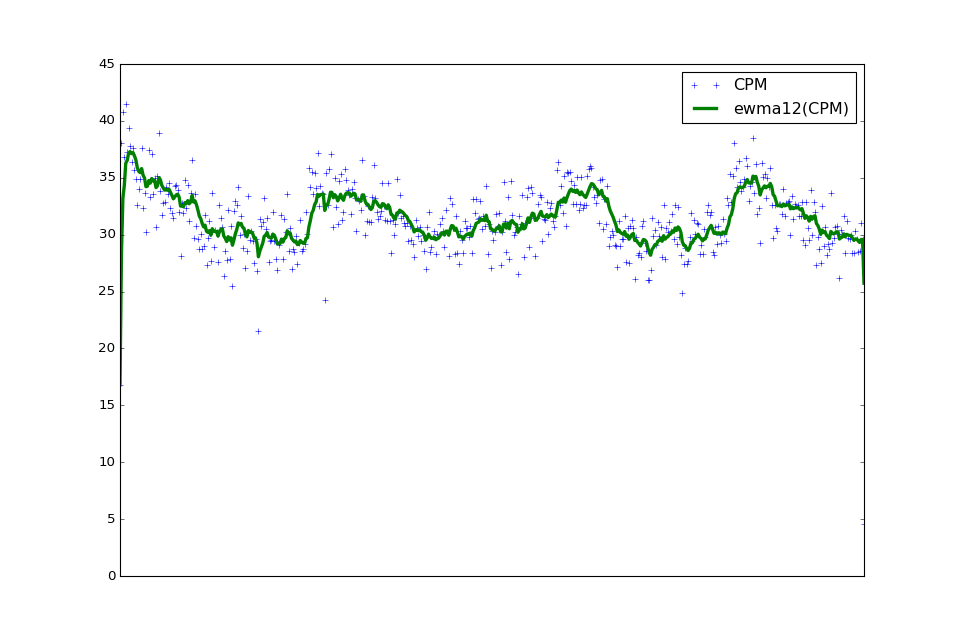

In [40]:
plt.figure(figsize=(12, 8))
def plot_clicks(sr, avg_sr):
    ax = sr.plot(style='+', figsize=(12, 8))
    avg_sr.plot(ax=ax, style='g-', lw=3, label='ewma12(CPM)')
    ax.legend()
    # From http://stackoverflow.com/a/13674286/548792
    ax.xaxis.set_minor_locator(dates.AutoDateLocator())
    ax.xaxis.set_minor_locator(dates.HourLocator(range(0, 24, 6)))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%m'))
    ax.xaxis.set_major_locator(dates.HourLocator(range(0, 24, 12)))
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n%b %d\n%Y'))
    ax.xaxis.grid(True, which="minor")
    return ax

sr = df.loc[:, (slice(None), 'clicks')].sum(axis=1)
sr.name = 'CPM'
sr, avg_sr = resample_sr(sr)
plot_clicks(sr, avg_sr)

<IPython.core.display.Javascript object>


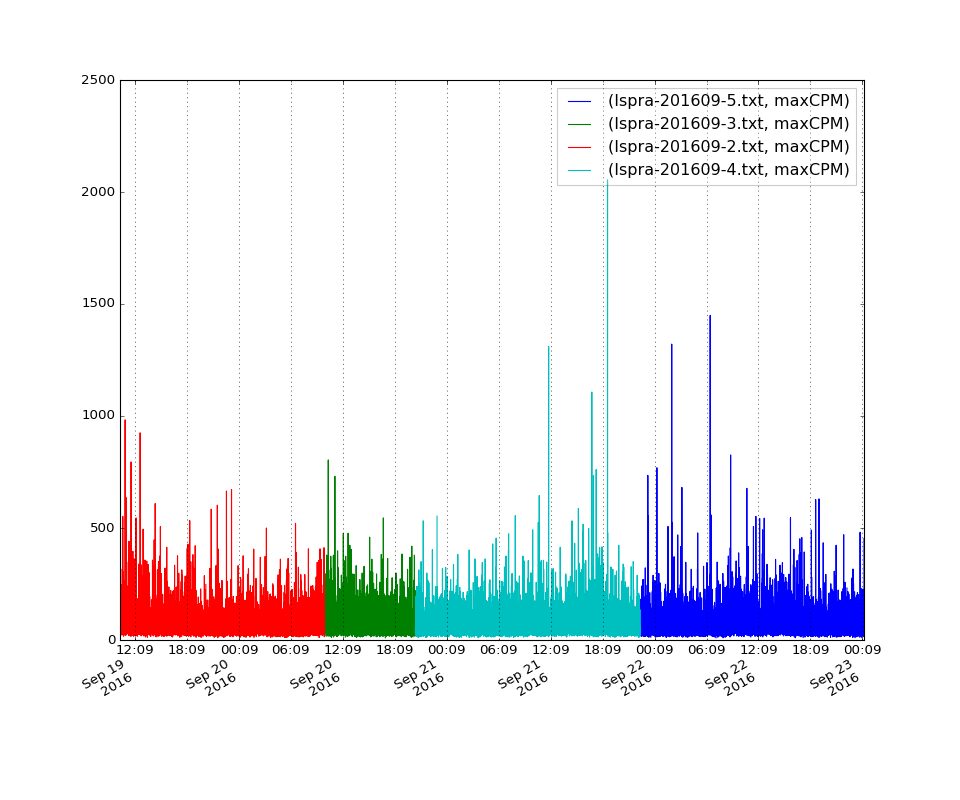

In [41]:
def plot_maxcpm(df):
    df = df.copy()
    df[df < 10] = np.NaN
    df = df.dropna(1, 'all')
    ax = df.plot(figsize=(12, 10));
    ax.legend(framealpha=0.2);
    # From http://stackoverflow.com/a/13674286/548792
    ax.xaxis.set_minor_locator(dates.AutoDateLocator())
    ax.xaxis.set_minor_locator(dates.HourLocator(range(0, 24, 6)))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%m'))
    ax.xaxis.set_major_locator(dates.HourLocator(range(0, 24, 12)))
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n%b %d\n%Y'))
    ax.xaxis.grid(True, which="minor")


#%matplotlib notebook
plot_maxcpm(df.loc[:, (slice(None), 'maxCPM')])


ddsfds

dsf

ds

dsf

dsf

sdf

sf

df

dsf

sdf

ds

fd

fsdf

sdf

dsf

dsf

sd

d